In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# set seed
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

CUDA is available!  Training on GPU ...


### 1. Dataloader
 source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
import pickle
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
   
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(root_dir + csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(
            self.root_dir,
            str(self.df.iloc[idx]['molecule_name']) + '_' + str(self.df.iloc[idx]['id']) + '.pkl'
        )
        
        with open (img_name, 'rb') as fp:
            image = pickle.load(fp)
        
        for c in range(5):
            image[c] = np.clip(image[c], 0, 255) / 255
        
        img = torch.from_numpy(np.array(image))
        img = img.type(torch.FloatTensor)
        
        sample = {'image': img,
                  'target': self.df.iloc[idx]['scalar_coupling_constant']}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample['image'], sample['target']

In [4]:
images_path ="../Data/full-images-1jhn/Image_1JHN/"

image_dataset = CustomImageDataset(
    csv_file='description.csv',
    root_dir=images_path)

## 2. Cross validation

In [5]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)

df = pd.read_csv(images_path + 'description.csv', index_col = 0)
df.reset_index(drop=True, inplace=True)

X = df[['id', 'molecule_name']].copy()
y = df['scalar_coupling_constant']
groups = df['molecule_name'].unique()

folds = []
for train_idx, valid_idx in group_kfold.split(X, y, X['molecule_name']):
    folds.append([train_idx, valid_idx])

In [6]:
index_fold = 1

In [7]:
# from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 300

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5, 0.5))
    ])

train_data = CustomImageDataset(
    csv_file='description.csv',
    root_dir = images_path,
#     transform=transform
)

train_idx, valid_idx = folds[index_fold][0], folds[index_fold][1]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers
                                          )
valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           sampler=valid_sampler,
                                           num_workers=num_workers
                                          )

In [15]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=5, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(4096),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            #nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(512),
            nn.Dropout(p=0.1),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [16]:
from functions_refactor import RAdam

# specify loss function (categorical cross-entropy)
criterion = nn.SmoothL1Loss()

# specify optimizer
optimizer = RAdam(model.parameters(), lr=0.0001)
clip = 2

In [17]:
# create a complete CNN
model = CNN().cuda()

In [18]:
# number of epochs to train the model
import time
n_epochs = 500
loss_per_iter = []
start_time = time.time()

valid_loss_min = np.Inf # track change in validation loss

output_file_nb = 0
max_output_file_nb = 50

for epoch in range(1, n_epochs+1):

    if (time.time() - start_time) / 3600 > 1:
        output_file_nb += 1
        print('Last iteration ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_last.pt')
        break
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for ind, (data, target) in enumerate(train_loader):
        print(ind, end='\r')
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output.view(data.shape[0]), target.float())
        loss.backward()
        #clip_grad_value_(model.parameters(),clip)
        optimizer.step()
    
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)    
        loss = criterion(output.view(data.shape[0]), target.float())    
        valid_loss += loss.item() * data.size(0)
 
    # calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    loss_per_iter.append([train_loss, valid_loss])
    
#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         output_file_nb += 1
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model.state_dict(), f'model_best.pt')
#         valid_loss_min = valid_loss
        
#         if epoch > 20:
#             output_file_nb += 1
#             torch.save(model.state_dict(), f'model_t{round(train_loss, 3)}_v{round(valid_loss, 3)}_ep{epoch}.pt')
        
#     elif valid_loss <= 1.1 * valid_loss_min and epoch > 20:
#         output_file_nb += 1
#         print('Validation loss saved at ({:.6f}).  Saving model ...'.format(valid_loss))
#         torch.save(model.state_dict(), f'model_t{round(train_loss, 3)}_v{round(valid_loss, 3)}_ep{epoch}.pt')
    
#     if output_file_nb > max_output_file_nb: break

Epoch: 1 	Training Loss: 47.040304 	Validation Loss: 46.851008


KeyboardInterrupt: 

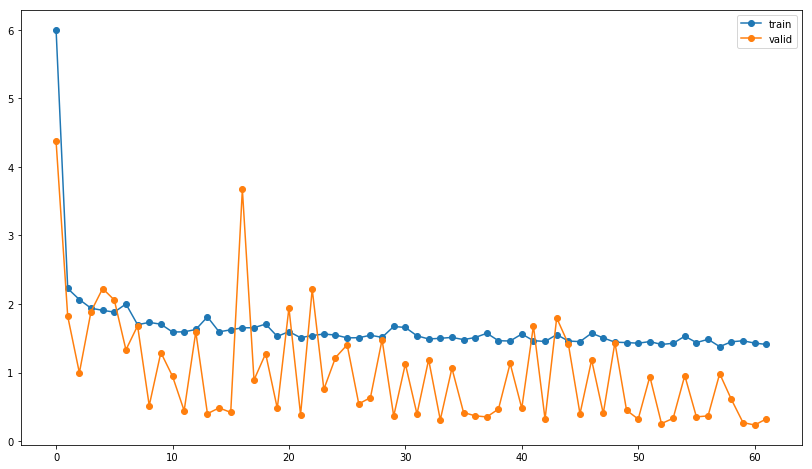

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.plot(np.array(loss_per_iter)[:, 0], 'o-', label = 'train')
plt.plot(np.array(loss_per_iter)[:, 1], 'o-', label = 'valid')
plt.legend()
plt.show()

In [13]:
print(np.array(loss_per_iter)[:, 0].min())
print(np.array(loss_per_iter)[:, 1].min())

1.3791749691475224
0.23511967740228787
